In [2]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.2 MB/s eta 0:00:00


In [3]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from unidecode import unidecode
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"
pd.options.display.float_format = '{:.0f}'.format

In [4]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

path = "/content/drive/MyDrive/CAFO_data/Europe/"

Mounted at /content/drive


In [7]:
df = pd.read_csv(f"{path}F6_1_Total Information on Installations.csv",\
                 low_memory=False)

# Select the farms and rename the ID column
df = df[df['IEDActivityName'].str.contains('Intensive rearing')].\
        rename(columns={"InstallationInspireID": "FarmID"})

# There can be multiple records of the same farm performing the same
# activity. These have different values for columns related to features
# and permitting. These seem to be something to do with reconsidering
# the permit and perhaps granting exemptions, rather than with distinct
# facilities, so it seems OK to drop these duplicates.

# EXAMPLE:
#display(cafos[cafos["FarmID"] == "AT.CAED/9008391271161.INSTALLATION"])
df.drop_duplicates(subset=["FarmID", "IEDActivityName"], inplace=True)

cafos = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))



cafos = cafos.drop(columns=["Longitude", "Latitude",\
                        "installationName",\
                        "installationNameConfidentialityReason",\
                        "addressConfidentialityReason",\
                        "IEDActivityCode",\
                        "CityofFacility", "siteVisitNumber", "relevantChapter",\
                        "permitGranted", "permitReconsidered", "permitUpdated",\
                        "permitURL", "featureType", "featureValue"])

In [8]:
# Basic info

print(f"Total facilities: {len(cafos)}")
print(f"Valid geometries: {cafos['geometry'].is_valid.value_counts().loc[True]}")

print("\n --", cafos["IEDActivityName"].value_counts())
print("\n --", cafos["InstallationStatus"].value_counts())

Total facilities: 23512
Valid geometries: 23512

 -- IEDActivityName
Intensive rearing of poultry with more than 40,000 places for poultry                     11532
Intensive rearing of pigs with more than 2,000 places for production pigs (over 30 kg)     9314
Intensive rearing of pigs with more than 750 places for sows                               2666
Name: count, dtype: int64

 -- InstallationStatus
functional        22269
notRegulated        592
disused             408
decommissioned      243
Name: count, dtype: int64


In [7]:
# Translate the very long names into more manageable ones

activity_dict = {"Intensive rearing of poultry with more than 40,000 places for poultry":\
                 "Poultry, 40000",\
                 "Intensive rearing of pigs with more than 2,000 places for production pigs (over 30 kg)":\
                 "Pigs, 2000",\
                 "Intensive rearing of pigs with more than 750 places for sows":\
                 "Sows, 750"}
cafos["Description"] = ""
for old, new in activity_dict.items():
  cafos.loc[cafos['IEDActivityName'] == old, ["Description"]] = new

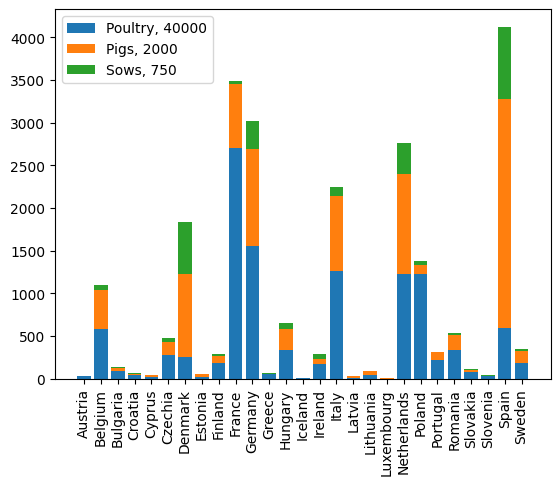

In [8]:
# Facilities by country

# Some of these countries don't report any pig facilities; need to
# account for that
all_countries = cafos[cafos["Description"] == "Poultry, 40000"]\
                     ["countryName"].unique()

# For stacking bar charts
bottom = np.zeros(len(all_countries))

for item in cafos["Description"].unique():
  to_plot = cafos[cafos["Description"] == item]
  to_plot = to_plot["countryName"].value_counts()

  # Add zeros for countries not reporting any facilities
  if "Poultry" not in item:
    zero_countries = [c for c in all_countries if c not in to_plot.index]
    for country in zero_countries:
      to_plot.loc[country] = 0

  to_plot = to_plot.sort_index()
  x = to_plot.index
  height = to_plot.values
  plt.bar(x, height, bottom=bottom, label=item)
  bottom += height
  plt.legend()
  plt.xticks(rotation=90)


In [9]:
%%skip
# European countries classified as middle-income for 2024-2025
# blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025
# No middle-income countries are in the farms dataset

df = pd.read_excel(f"{path}CLASS.xlsx", sheet_name=0)
df = df[df['Region'] == "Europe & Central Asia"]
df = df[df["Income group"].isin(["Upper middle income", "Lower middle income", "Not Classified"])]

In [10]:
# Well, let's see what large-scale farms look like in a few eastern countries
# then. Poland has a lot of buildings so maybe don't use that country.

min_building_size = 200
countries = ["BGR", "LTU", "SVK"]#, ROU
crs_dict = {"LTU": "EPSG:3346", "SVK": "EPSG:8352", "ROU":"EPSG:3844",\
            "BGR":"EPSG:7801"}
country_dict = {"LTU": "Lithuania", "SVK": "Slovakia",\
                "BGR": "Bulgaria"}#, "ROU": "Romania"

for name in country_dict.values():
  print(f"There are {len(cafos[cafos['countryName'] == name])} farms in {name}")

There are 91 farms in Lithuania
There are 108 farms in Slovakia
There are 131 farms in Bulgaria


In [11]:
%%skip

borders = gpd.read_file(f'{path}shapefiles/ne_10m_admin_0_countries.shp')
for country in countries:
  border = borders[borders['SOV_A3'].str.match(country)]
  geom = geemap.geopandas_to_ee(border[['geometry']])

  buildings = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/{country}")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(geom)
  )

  utils.write_to_file(buildings, f"{country}_buildings_{min_building_size}_sq_m",\
                      'Europe')

utils.ee_task_status()

In [12]:
%%time
# Takes about 7 mins for LTU, SVK, BGR, ROU; 2.5 mins if omit ROU

bldgs = []
for country in countries:
  gdf = gpd.read_file(f"{path}{country}_buildings_{min_building_size}_sq_m.geojson")
  gdf.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
  print(f"There are {len(gdf)} buildings > {min_building_size} sq m in {country}")
  bldgs.append(gdf)

There are 460854 buildings > 200 sq m in BGR
There are 261504 buildings > 200 sq m in LTU
There are 511666 buildings > 200 sq m in SVK
CPU times: user 2min 40s, sys: 6.25 s, total: 2min 47s
Wall time: 2min 57s


In [13]:

farm_dist = 150
not_farm_dist = 1000

farm_dict = {}
other_dict = {}
for idx, country in enumerate(countries):
  farms = cafos[cafos['countryName'] == country_dict[country]]
  df1, df2 = explore.join_farms_and_buildings(farms,\
                                              bldgs[idx],\
                                              farm_dist,\
                                              not_farm_dist,\
                                              crs_dict[country])

  farm_dict[country] = df1
  other_dict[country] = df2

  print(f"There are {len(cafos[cafos['countryName'] == country_dict[country]])}\
 farms in {country_dict[country]}")
  print(f" --There are {len(df1)} buildings within {farm_dist} m of\
 farm coords")
  print(f" --There are {len(df2)} buildings >{not_farm_dist} m from\
 farm coords (any farm type)")

There are 131 farms in Bulgaria
 --There are 1026 buildings within 150 m of farm coords
 --There are 454068 buildings >1000 m from farm coords (any farm type)
There are 91 farms in Lithuania
 --There are 738 buildings within 150 m of farm coords
 --There are 258562 buildings >1000 m from farm coords (any farm type)
There are 108 farms in Slovakia
 --There are 1054 buildings within 150 m of farm coords
 --There are 502950 buildings >1000 m from farm coords (any farm type)


In [14]:
new_total = 0
for country, name in country_dict.items():
  n = len(cafos[cafos['countryName'] == name])
  print(f"Started with {n} farms in {name}")

  n = len(farm_dict[country].groupby("Parent coords"))
  print(f" -- {n} are associated with buildings > {min_building_size} sq m")
  new_total += n

print(f"There is now a total of {new_total} farms")

Started with 91 farms in Lithuania
 -- 79 are associated with buildings > 200 sq m
Started with 108 farms in Slovakia
 -- 101 are associated with buildings > 200 sq m
Started with 131 farms in Bulgaria
 -- 87 are associated with buildings > 200 sq m
There is now a total of 267 farms


In [15]:
# Calculate the lengths and aspect ratios of those buildings
# Keep only the largest building per farm

farm_list = []
for country, df in farm_dict.items():
  df = explore.get_dimensions(farm_dict[country], crs=crs_dict[country])
  farm_list.append(df)

farm_buildings = pd.concat(farm_list)

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")

2818 buildings --> 267 buildings


,5%-ile area (sq m),50%-ile area (sq m),Max area (sq m)
Lithuania - Pigs,1614,4180,25610
Lithuania - Poultry,1824,2987,26840
Slovakia - Pigs,1279,2938,16910
Slovakia - Poultry,944,1569,15462
Bulgaria - Pigs,693,1577,6164
Bulgaria - Poultry,847,1692,9116


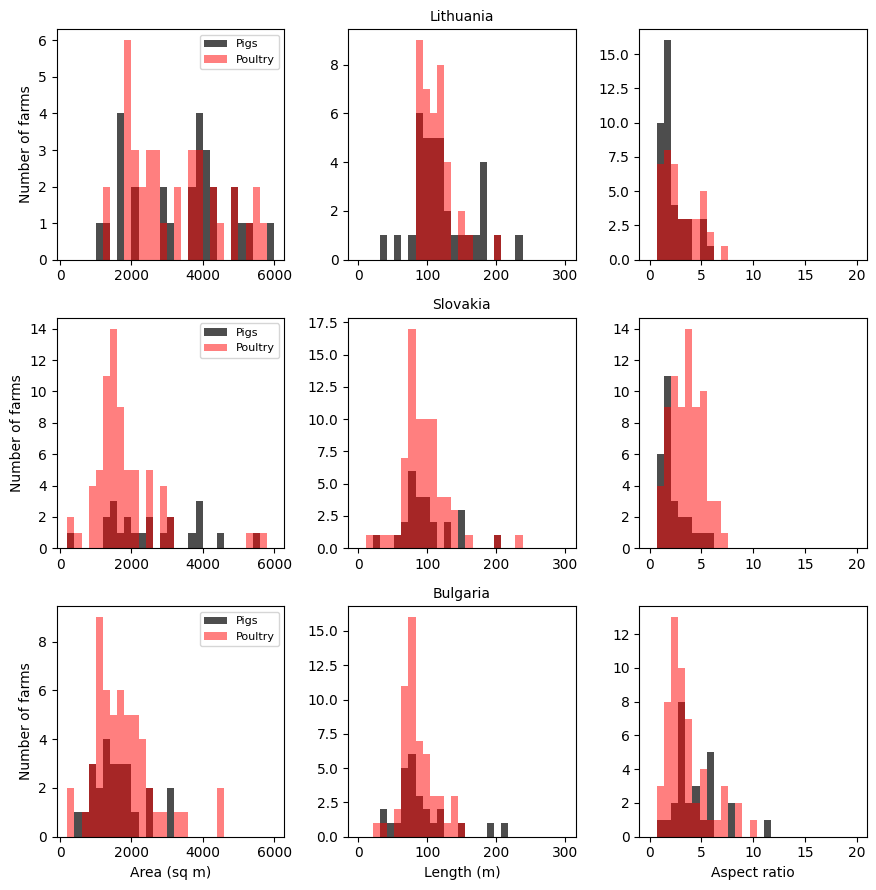

In [59]:
bins = {}
bins['Area (sq m)'] = np.linspace(min_building_size, 6000, 30)
bins['Length (m)'] = np.linspace(0, 300, 30)
bins['Aspect ratio'] = np.linspace(0, 20, 30)

_, (ax0, ax1, ax2) = plt.subplots(3, 3, figsize=(9, 9))
df = pd.DataFrame()

def histos(name, axes):
  to_plot = max_farm_bldgs[max_farm_bldgs['countryName'] == name]
  pigs = to_plot[to_plot['Description'].isin(['Pigs, 2000', 'Pigs, 750'])]
  poultry = to_plot[to_plot['Description'].isin(['Poultry, 40000'])]

  for col, ax in zip(["Area (sq m)", "Length (m)", "Aspect ratio"],\
                     axes):
    ax.hist(pigs[col], bins=bins[col], color='0.3',\
           histtype='stepfilled', label="Pigs")

    ax.hist(poultry[col], bins=bins[col], color='r',\
           histtype='stepfilled', alpha=0.5, label='Poultry')

    if col == "Area (sq m)":
      ax.legend(fontsize=8)
      ax.set_ylabel("Number of farms")
    if col == "Length (m)":
      ax.set_title(name, fontsize=10)
    if name == "Bulgaria":
      ax.set_xlabel(col)

  for df1, animal in zip([pigs, poultry], ["Pigs", "Poultry"]):
    df.loc[f"{name} - {animal}", "5%-ile area (sq m)"] = df1["Area (sq m)"].quantile(0.05)
    df.loc[f"{name} - {animal}", "50%-ile area (sq m)"] = df1["Area (sq m)"].quantile(0.5)
    df.loc[f"{name} - {animal}", "Max area (sq m)"] = df1["Area (sq m)"].max()

histos("Lithuania", ax0)
histos("Slovakia", ax1)
histos("Bulgaria", ax2)

display(df)

plt.tight_layout()


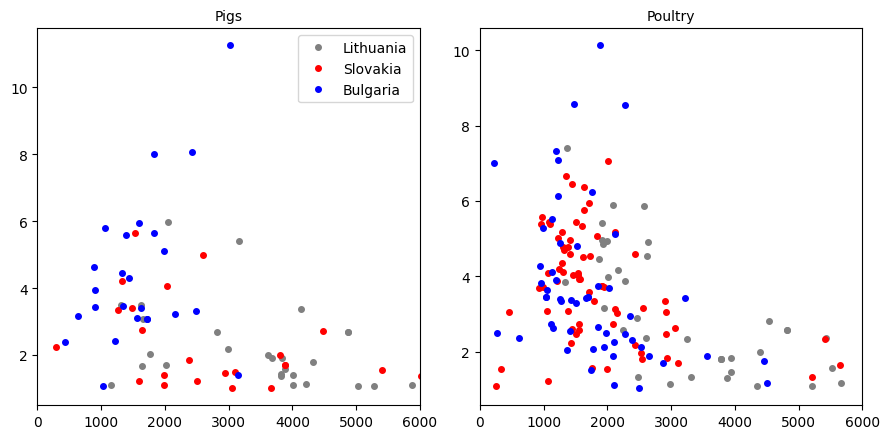

In [51]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4.5))

for animal, ax in zip (["Pigs", "Poultry"], [ax0, ax1]):
  to_plot = max_farm_bldgs[max_farm_bldgs['Description'].str.contains(animal)]
  for country, color in zip(["Lithuania", "Slovakia", "Bulgaria"], ['0.5', 'r', 'b']):
    plotme = to_plot[to_plot['countryName'] == country]
    ax.plot(plotme["Area (sq m)"], plotme["Aspect ratio"], color=color,\
            marker="o", ms=4, ls='', label=country)
    if animal == "Pigs":
      ax.legend()
    ax.set_title(animal, fontsize=10)
    ax.set_xlim([0, 6000])

plt.tight_layout()

## Visual inspection

My impressions from looking at random samples of these farms are:

1.   There is quite a lot of variation in farm styles/building characteristics. Relatively few of them look like "standard CAFOs" with long, narrow, parallel, white-roofed buildings.
1. Some of them look kind of... Soviet. My impression is that industrial animal farming has been around long enough in these countries for them to have quite a lot of larger, older, non-standardized farms.
1. Some of the small aspect ratios can be explained by the building footprint dataset lumping buildings together or creating irregular building outlines
1. The coordinates appear to be pretty good; coincident with farm buildings.



In [63]:
explore.loop_over_buildings(max_farm_bldgs.sample(20))

Working on feature 0 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
453,"POLYGON ((24.66173 54.35952, 24.66189 54.35919...","POLYGON ((24.66375365912669 54.359421332806, 2...",1653,Lithuania,"Pigs, 2000",90,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 1 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
388,"POLYGON ((24.99045 43.44818, 24.99048 43.44833...","POLYGON ((24.99074101550847 43.44834114762767,...",1190,Bulgaria,"Poultry, 40000",69,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 2 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
640,"POLYGON ((26.57988 43.61945, 26.58012 43.61956...",POLYGON ((26.580469034674604 43.61859376147525...,1692,Bulgaria,"Poultry, 40000",82,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 3 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
226,"POLYGON ((25.59705 43.04085, 25.59707 43.04071...",POLYGON ((25.598401859787874 43.04050444299599...,3218,Bulgaria,"Poultry, 40000",121,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 4 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
237,"POLYGON ((24.52230 54.95963, 24.52208 54.95955...",POLYGON ((24.524795947452137 54.95897791600901...,4541,Lithuania,"Poultry, 40000",163,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 5 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
998,"POLYGON ((17.95428 48.84591, 17.95415 48.84639...",POLYGON ((17.955413131891845 48.84507175547645...,1840,Slovakia,"Poultry, 40000",108,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 6 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
435,"POLYGON ((18.07244 48.63495, 18.07257 48.63507...","POLYGON ((18.07230144563191 48.63330364469761,...",1455,Slovakia,"Poultry, 40000",91,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 7 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
802,"POLYGON ((21.28342 48.68178, 21.28350 48.68213...",POLYGON ((21.283057598437427 48.68096429318783...,10832,Slovakia,"Poultry, 40000",134,1


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 8 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
623,"POLYGON ((19.20195 48.58246, 19.20221 48.58248...",POLYGON ((19.202123033752414 48.58151504091388...,1535,Slovakia,"Poultry, 40000",81,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 9 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
63,"POLYGON ((23.63506 56.26339, 23.63613 56.26329...",POLYGON ((23.639272178441377 56.26544307839361...,24477,Lithuania,"Pigs, 2000",450,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 10 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
1016,"POLYGON ((18.10661 48.95541, 18.10688 48.95540...",POLYGON ((18.104917645222418 48.95585884376655...,2922,Slovakia,"Poultry, 40000",132,2


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 11 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
435,"POLYGON ((24.90561 42.04929, 24.90578 42.04958...",POLYGON ((24.907367877251012 42.05003748139794...,1858,Bulgaria,"Poultry, 40000",101,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 12 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
192,"POLYGON ((25.37496 43.23262, 25.37506 43.23271...",POLYGON ((25.376846551738062 43.23166798167160...,1715,Bulgaria,"Pigs, 2000",79,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 13 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
732,"POLYGON ((23.20945 42.79301, 23.21015 42.79323...","POLYGON ((23.21211084029295 42.7919805553428, ...",4504,Bulgaria,"Poultry, 40000",94,1


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 14 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
288,"POLYGON ((24.57764 54.90693, 24.57777 54.90693...",POLYGON ((24.581290912388607 54.90708883503666...,6063,Lithuania,"Poultry, 40000",128,1


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 15 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
183,"POLYGON ((24.33788 55.13571, 24.33817 55.13570...",POLYGON ((24.341550324022617 55.13545543107211...,3887,Lithuania,"Pigs, 2000",99,2


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 16 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
587,"POLYGON ((18.60509 48.72347, 18.60534 48.72344...","POLYGON ((18.60443154653123 48.72172344139191,...",3878,Slovakia,"Pigs, 2000",101,2


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 17 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
821,"POLYGON ((25.77627 42.35645, 25.77630 42.35660...",POLYGON ((25.777401742849893 42.35562058324187...,908,Bulgaria,"Pigs, 2000",57,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 18 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
493,"POLYGON ((26.14850 43.87089, 26.14853 43.87059...",POLYGON ((26.150765799152886 43.87098962435358...,1022,Bulgaria,"Pigs, 2000",36,1


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 19 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
940,"POLYGON ((18.85238 49.18170, 18.85237 49.18173...",POLYGON ((18.854460375065962 49.18108539464793...,1415,Slovakia,"Poultry, 40000",92,5


Enter reject to reject, exit to exit, or any key to continue  n


[]

## The not-farm sample

In [ ]:
%%skip
# Need to handle the countries and CRSs

# The not-farm sample will match the Area distribution of the combined pig and
# poultry df
sampled = explore.stratified_sample(max_farm_bldgs, other_buildings, 'Area (sq m)',\
                                 bins=bins['Area (sq m)'])

# Calculate length and aspect ratio for the not-farm buildings
notfarm_buildings = explore.get_dimensions(sampled, crs=crs)
print(f"We have {len(notfarm_buildings)} not-farm buildings")

# Sometimes there are a few aspect ratios that seem unrealistic, probably
# where the building footprint database has confused roads with buildings.
# Drop these.
notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

# This final number of not-farm buildings can be a bit less than the number of
# farm buildings, if some of the farm buildings have areas outside
# bins['Area (sq m)']
print(f"We have {len(notfarm_buildings)} not-farm buildings")

## The final dataset

In [ ]:
# Create the final dataset that will be used for training.

# -- Farm buildings
farms_cleaned.loc[:, "Dataset name"] = "Europe"
farms_cleaned = explore.re_order(farms_cleaned)

# -- Not-farm buildings
coldict = {"Dataset name": "Europe", "Parent coords": None,\
           "Farm type": "Non-farm", "Number of animals": np.nan}
for col, val in coldict.items():
  notfarms_cleaned.loc[:, col] = val

notfarms_cleaned = explore.re_order(notfarms_cleaned)

chl = pd.concat([farms_cleaned, notfarms_cleaned])
chl.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/Europe_bldgs.pkl')